In [2]:
import sqlite3
import pandas as pd
import ast
import numpy as np  

This file will show a discovery phase/process used before creating `data_cleanser.py` file which automates the cleaning and updates processes.

# Connecting SQLite3 Database

First I'll connect to the database to determine which tables are contained in the database.

In [3]:
con = sqlite3.connect('cademycode.db')
cur = con.cursor()

# We'll read all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type='table';")] # .fetchall()
print(table_list)

[('cademycode_students',), ('cademycode_courses',), ('cademycode_student_jobs',)]


# Extract tables from db file

I'll extract the tables using simple query statements and save them to python variables.

In [4]:
students = pd.read_sql_query("SELECT * from cademycode_students", con)
career_paths = pd.read_sql_query("SELECT * from cademycode_courses", con)
students_jobs = pd.read_sql_query("SELECT * from cademycode_student_jobs", con)

In [5]:
print('students:', len(students))
print('career_paths:', len(career_paths))
print('students_jobs:', len(students_jobs))

students: 5000
career_paths: 10
students_jobs: 13


# Working with the `Students` table

Let's work with the students file first since it is the largest. I'll start by taking a look at the first few rows of data to get a general sense of what the structure looks like.

In [6]:
students.head()

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs
0,1,Annabelle Avery,1943-07-03,F,"{""mailing_address"": ""303 N Timber Key, Irondal...",7.0,6.0,1.0,4.99
1,2,Micah Rubio,1991-02-07,M,"{""mailing_address"": ""767 Crescent Fair, Shoals...",7.0,5.0,8.0,4.4
2,3,Hosea Dale,1989-12-07,M,"{""mailing_address"": ""P.O. Box 41269, St. Bonav...",7.0,8.0,8.0,6.74
3,4,Mariann Kirk,1988-07-31,F,"{""mailing_address"": ""517 SE Wintergreen Isle, ...",6.0,7.0,9.0,12.31
4,5,Lucio Alexander,1963-08-31,M,"{""mailing_address"": ""18 Cinder Cliff, Doyles b...",7.0,14.0,3.0,5.64


Next I'll examine the datatypes of each column and check for any null values using the `.info()` funtion.  

In [7]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    5000 non-null   int64 
 1   name                    5000 non-null   object
 2   dob                     5000 non-null   object
 3   sex                     5000 non-null   object
 4   contact_info            5000 non-null   object
 5   job_id                  4995 non-null   object
 6   num_course_taken        4749 non-null   object
 7   current_career_path_id  4529 non-null   object
 8   time_spent_hrs          4529 non-null   object
dtypes: int64(1), object(8)
memory usage: 351.7+ KB


A couple things I notice when examining the DataFrame so far:
* `contact_info` appears to be a dictionary, which will require additional work to explode it into separate columns 
* Each row has a UUID, which means one student can only be one row
* `dob` seems to be date of birth, will want to make sure it is a datetime object
    * Calculating age from DoB might be useful as a grouping column
* None of the numerical columns are coming in as floats or integers
    * `job_id` and `current_career_path_id` should be treated as categorical data since they are IDs
* It looks like there is missing data in `job_id`, `num_course_taken`, `current_career_path_id`

# Calculating approximate age

I'll convert `dob` into approximate age. This provides a couple benefits over a datetime field:

* To an analytics team who's trying to tell a story with numbers, age makes more aesthetic sense.
* This creates a new ordinal or even categorical field for analysts to dive into.

In [8]:
now = pd.to_datetime('now')
#students['age'] = (now - pd.to_datetime(students['dob'])).astype('<m8[Y]') # deprecated because years are not all the same length
#students['age'] = (now - pd.to_datetime(students['dob']))/pd.Timedelta(days=365.25) # not exact but close enough

# Accurate age calculation
dob = pd.to_datetime(students['dob'])
students['age'] = (now.year - dob.dt.year) - (
    (now.month < dob.dt.month) | ((now.month == dob.dt.month) & (now.day < dob.dt.day))
)

students['age_group'] = np.int64((students['age']/10))*10

In [9]:
# Accurate age calculation
dob = pd.to_datetime(students['dob'])
students['age'] = (now.year - dob.dt.year) - (
    (now.month < dob.dt.month) | ((now.month == dob.dt.month) & (now.day < dob.dt.day))
)

In [10]:
students.head()

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group
0,1,Annabelle Avery,1943-07-03,F,"{""mailing_address"": ""303 N Timber Key, Irondal...",7.0,6.0,1.0,4.99,82,80
1,2,Micah Rubio,1991-02-07,M,"{""mailing_address"": ""767 Crescent Fair, Shoals...",7.0,5.0,8.0,4.4,34,30
2,3,Hosea Dale,1989-12-07,M,"{""mailing_address"": ""P.O. Box 41269, St. Bonav...",7.0,8.0,8.0,6.74,35,30
3,4,Mariann Kirk,1988-07-31,F,"{""mailing_address"": ""517 SE Wintergreen Isle, ...",6.0,7.0,9.0,12.31,37,30
4,5,Lucio Alexander,1963-08-31,M,"{""mailing_address"": ""18 Cinder Cliff, Doyles b...",7.0,14.0,3.0,5.64,62,60


## Explode the dictionary

In [11]:
explode_contact = pd.json_normalize(students['contact_info'])
explode_contact.dtypes

Series([], dtype: object)

Interestingly enough, pandas imported the `contact_info` column as a string type rather than as JSON. This adds an extra step and requires me to convert the strings to dictionaries, and then explode:

In [12]:
students['contact_info'] = students['contact_info'].apply(lambda x: ast.literal_eval(x))
explode_contact = pd.json_normalize(students['contact_info'])
students = pd.concat([students.drop(columns=['contact_info']), explode_contact], axis=1)

In [13]:
students.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,mailing_address,email
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,82,80,"303 N Timber Key, Irondale, Wisconsin, 84736",annabelle_avery9376@woohoo.com
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.4,34,30,"767 Crescent Fair, Shoals, Indiana, 37439",rubio6772@hmail.com
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,35,30,"P.O. Box 41269, St. Bonaventure, Virginia, 83637",hosea_dale8084@coldmail.com
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,37,30,"517 SE Wintergreen Isle, Lane, Arkansas, 82242",kirk4005@hmail.com
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,62,60,"18 Cinder Cliff, Doyles borough, Rhode Island,...",alexander9810@hmail.com


After exploding the dictionary column, it could be worth spliting the `mailing_address` column into `street`, `city`, `state`, `zip_code` columns.

In [14]:
split_address = students.mailing_address.str.split(',', expand=True)
split_address.columns = ['street', 'city', 'state', 'zip_code']
students = pd.concat([students.drop('mailing_address', axis=1), split_address], axis=1)
students.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,82,80,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.4,34,30,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,35,30,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,37,30,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,62,60,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737


In [15]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    5000 non-null   int64 
 1   name                    5000 non-null   object
 2   dob                     5000 non-null   object
 3   sex                     5000 non-null   object
 4   job_id                  4995 non-null   object
 5   num_course_taken        4749 non-null   object
 6   current_career_path_id  4529 non-null   object
 7   time_spent_hrs          4529 non-null   object
 8   age                     5000 non-null   int32 
 9   age_group               5000 non-null   int64 
 10  email                   5000 non-null   object
 11  street                  5000 non-null   object
 12  city                    5000 non-null   object
 13  state                   5000 non-null   object
 14  zip_code                5000 non-null   object
dtypes: i

## Handling Missing Data

`num_course_taken`

Let's examine the missing data to determine if the missing data is missing at random, structurally missing, or missing not at random:

In [16]:
missing_course_taken = students[students[['num_course_taken']].isnull().any(axis=1)]
display(missing_course_taken)

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
25,26,Doug Browning,1970-06-08,M,7.0,None,5.0,1.92,55,50,doug7761@inlook.com,P.O. Box 15845,Devine,Florida,23097
26,27,Damon Schrauwen,1953-10-31,M,4.0,None,10.0,3.73,72,70,damon9864@woohoo.com,P.O. Box 84659,Maben,Georgia,66137
51,52,Alisa Neil,1977-05-28,F,5.0,None,8.0,22.86,48,40,alisa9616@inlook.com,16 View Annex,Mosses,North Dakota,25748
70,71,Chauncey Hooper,1962-04-07,M,3.0,None,3.0,3.97,63,60,chauncey6352@woohoo.com,955 Dewy Flat,Slaughterville,South Carolina,22167
80,81,Ellyn van Heest,1984-06-28,F,3.0,None,10.0,12.39,41,40,ellyn_vanheest8375@hmail.com,872 Cider Glade,Chicken,Delaware,42689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4889,4890,Tegan Cochran,1970-11-08,F,5.0,None,8.0,22.75,55,50,tegan130@inlook.com,106 Sunny Nook,Vernal,Georgia,10769
4898,4899,Ruthann Oliver,1998-05-22,F,3.0,None,7.0,21.27,27,20,ruthann1124@woohoo.com,644 Merry Island,Green Valley,Wyoming,91273
4914,4915,Ernest Holmes,1995-03-11,M,7.0,None,9.0,26.5,30,30,ernest_holmes505@hmail.com,872 Wintergreen Harbor,Gallitzin borough,Maine,50103
4980,4981,Brice Franklin,1946-12-01,M,4.0,None,5.0,8.66,79,70,brice9741@coldmail.com,947 Panda Way,New Bedford village,Vermont,31232


Let's take a look at the distribution of missing and complete data grouped by the categorical data. If the distribution between the missing and non-missing data is similar, we can conclude that the data is MAR if no identifiable pattern is found. Generally, if something is MNAR or structurally missing, it should be visible by graphing the data.

<Axes: xlabel='sex'>

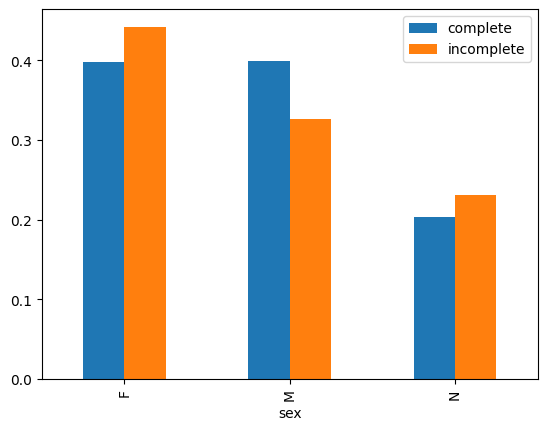

In [17]:
sg = (students.groupby('sex').count()['uuid']/len(students)).rename('complete')
mg = (missing_course_taken.groupby('sex').count()['uuid']/len(missing_course_taken)).rename('incomplete')
df = pd.concat([sg, mg], axis=1)
df.plot.bar()